# Solving an Inverse Problem with Physics-Informed Neural Networks (PINNs)

### Problem Statement:
We aim to find the scalar parameter $\alpha \in \mathbb{R}$ given a target function $\tilde{u}$. Specifically, we want to solve the following optimization problem:
$$
\text{arg}\min f(u,\tilde{u}) = \| u - \tilde{u} \|^2,
$$
where $u$ satisfies the boundary value problem described by a second-order Partial differential equation (PDE):
\begin{cases}
\displaystyle -\alpha \frac{d^2u}{dx^2} = f(x), \quad x \in \Omega = (0,1),\\​
 u(0) = u(1) =  0 . 
\end{cases}

### Given data:
The target function $\tilde{u}$ is given by:
$$\tilde{u} = \sin(\pi x)$$
  
The function $f(x)$, derived from the assumed true solution, is specified as:
$$f = 2 \pi^2 \sin(\pi x).$$

-----------------------------

# Objective

Our goal is to compute the value of $\alpha$ that best aligns the solution $u(x)$ of the PDE with the given $\tilde{u}(x)$.
To achieve this, we can utilize a Physics-Informed Neural Network (PINN) that integrates the differential equation as a part of its loss function.
This approach ensures that the learned solution not fits the data while respecting the underlying "physics" described by the PDE.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from DNN import DeepNet

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

I'm using:  cuda


In [2]:
def convert(x):
  return x.cpu().detach().numpy()

# Define the PINN model
we need to define the following components:
- The neural network architecture to approximate the solution $u(x)$.
- A parameter $\alpha$ to be optimized to approximate the parameter $\alpha$.

In [3]:
input = 
output =
hidden_layer =
activation_function =

FNN = DeepNet()
alpha = nn.Parameter().to(device)
FNN

SyntaxError: invalid syntax (3180295234.py, line 1)

# Define the points for training

In [ ]:
x0 = torch.Tensor().to(device)
x1 = torch.Tensor().to(device)
u_b0 = torch.Tensor().to(device)
u_b1 = torch.Tensor().to(device)

n_train_points =  # for train
n_data_points  = # for data interpolation
n_test_points  = # for test

x_train = 
x_data = 
x_test = 

Text(0.5, 1.0, 'Collocation Points')

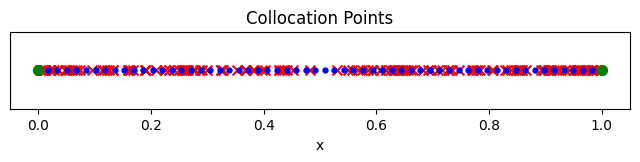

In [ ]:
plt.figure(figsize=(8, 1),num =1)  
plt.scatter(convert(x_train), np.zeros_like(convert(x_train)), color='red', s=50, marker='x', label='Collocation Points')
plt.scatter(convert(x_data), np.zeros_like(convert(x_data)), color='blue', s=50, marker='.', label='Data Points')

plt.scatter(convert(x0), np.zeros_like(convert(x0)), color='green', s=50)
plt.scatter(convert(x1), np.zeros_like(convert(x1)), color='green', s=50)
plt.xlabel('x')
plt.yticks([])  
plt.title('Collocation Points')


# Define the exact solution and the rhs of the PDE

In [ ]:
def exact_sol(x):
    return 

alpha_exact = 

def rhs(x):
    return 

u_exact_train = exact_sol(x_train)
rhs_train = rhs(x_train)
u_exact_data = exact_sol(x_data)
u_exact_test = exact_sol(x_test)

# Define the loss function

In [ ]:
def eval_loss_ode(Phi,x,rhs,alpha,metric):
    x.requires_grad_(True)

    u_NN = Phi(x)
    u_NN_x = torch.autograd.grad()[0]
    u_NN_xx = torch.autograd.grad()[0]

    return metric()

def eval_loss_pt(Phi,x,y):
    return ().pow(2).squeeze()

def eval_loss_data(Phi,x,data,metric):
    return metric()

# Train the model

In [ ]:
n_epochs = 10000
learining_rate = 1e-3
alpha = nn.Parameter(torch.Tensor([1]).to(device).requires_grad_(True)) #! what this carefully

optimizer = optim.Adam(list(FNN.parameters())+[alpha],lr = 1e-3) #! what this carefully
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,5000,0.5)

loss_values = np.empty([n_epochs+1,5]) #total,ode, b0,b1, data
alpha_values = np.empty([n_epochs+1])

MSE =  torch.nn.MSELoss()
STEP = 100 #save every 100 epochs

assert n_epochs%STEP == 0

err = np.empty([int(n_epochs/STEP)+1,2])
u_animate =  np.empty([int(n_epochs/STEP)+1,n_train_points])
err_animate = np.empty([int(n_epochs/STEP)+1,n_train_points])
k = 0 

for epoch in range(n_epochs+1):

    loss_ode = 

    loss_b0 = 
    loss_b1 = 

    loss_data = 

    loss = 

    # optimizer zero grad
    ...
    
    # loss backward
    ...
    
    # optimizer step
    ...
    
    # scheduler step
    ...


    loss_values[epoch,:] = np.stack([convert(loss),convert(loss_ode),convert(loss_b0),convert(loss_b1),convert(loss_data)])
    alpha_values[epoch] = alpha
    if epoch%STEP == 0:
      lr = np.array(scheduler.get_last_lr())
    #   u_NN_test =  FNN(x_test)
    #   err[k,:] = [L2_diff(convert(FNN(x_train)),u_exact_train), L2_diff(convert(u_NN_test),u_exact_test)]
    #   u_animate[k,:]  = convert(FNN(x_sort_train).squeeze())
    #   err_animate[k,:]= (np.abs(u_animate[k,:] - u_exact_train_sort.squeeze()))
      print(f'Epoch {epoch} || learning rate {lr.squeeze():.2e} ''\n'
            f'Global loss {loss_values[epoch,0]:.2e} || loss ode {loss_values[epoch,1]:.2e} || loss b0 {loss_values[epoch,2]:.2e} || loss b1 {loss_values[epoch,3]:.2e} || loss data {loss_values[epoch,4]:.2e}','\n')
      k+=1

Epoch 0 || learning rate 1.00e-03  || Error  Train 6.76e-310 || Error Test  6.76e-310
Global loss 1.66e+02 || loss ode 1.65e+02 || loss b0 0.00e+00 || loss b1 6.99e-02 || loss data 7.06e-01 

Epoch 100 || learning rate 1.00e-03  || Error  Train 4.90e-310 || Error Test  4.90e-310
Global loss 1.53e+01 || loss ode 9.50e+00 || loss b0 1.94e+00 || loss b1 2.47e+00 || loss data 9.40e-01 

Epoch 200 || learning rate 1.00e-03  || Error  Train 2.14e-312 || Error Test  3.40e-313
Global loss 3.89e-01 || loss ode 7.43e-02 || loss b0 1.70e-02 || loss b1 7.67e-02 || loss data 1.47e-01 

Epoch 300 || learning rate 1.00e-03  || Error  Train 1.27e-313 || Error Test  3.95e-323
Global loss 3.15e-01 || loss ode 1.87e-02 || loss b0 3.84e-02 || loss b1 4.88e-02 || loss data 1.39e-01 

Epoch 400 || learning rate 1.00e-03  || Error  Train 0.00e+00 || Error Test  6.37e-314
Global loss 3.89e-01 || loss ode 9.59e-02 || loss b0 4.39e-02 || loss b1 8.99e-02 || loss data 1.06e-01 

Epoch 500 || learning rate 1.00e-

# Visualize the loss function

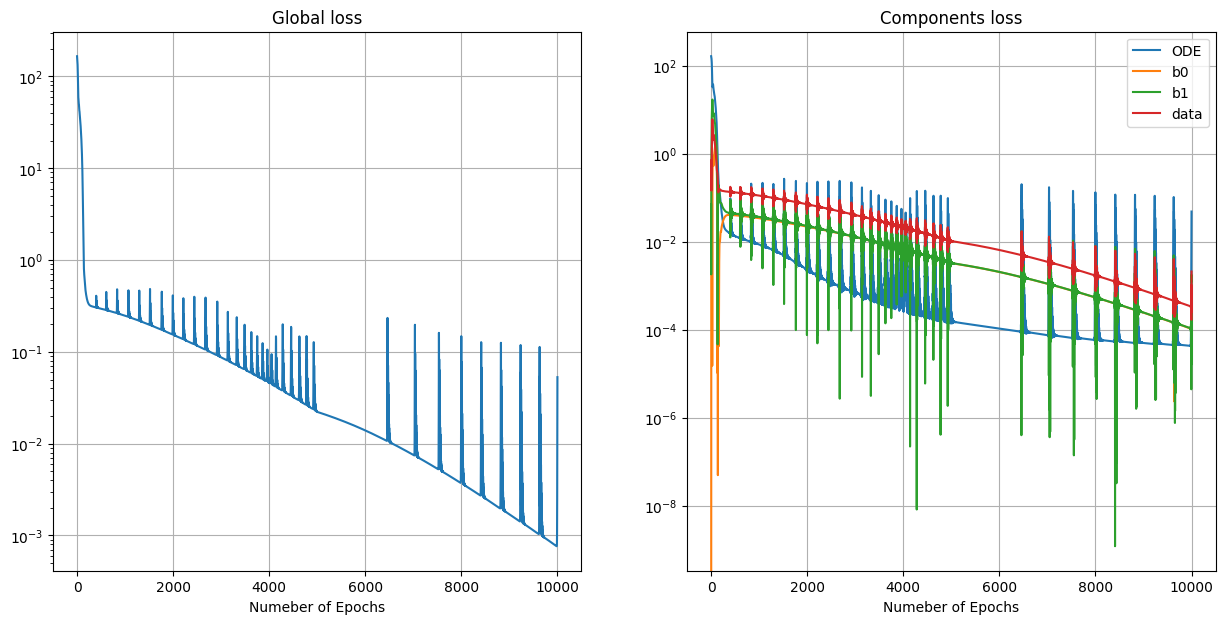

In [ ]:
epochs = range(n_epochs+1)
#y_lims = [np.min(loss_values)*0.8,np.max(loss_values)*1.2]

fig, axs = plt.subplots(1,2,figsize = (15,7), num =4)
axs[0].semilogy(epochs,loss_values[:,0])
axs[0].set_xlabel('Numeber of Epochs')
#axs[0].set_ylim(y_lims)
axs[0].grid('on')
axs[0].set_title('Global loss')

axs[1].semilogy(epochs,loss_values[:,1],label = 'ODE')
axs[1].semilogy(epochs,loss_values[:,2],label = 'b0' )
axs[1].semilogy(epochs,loss_values[:,3],label = 'b1' )
axs[1].semilogy(epochs,loss_values[:,4],label = 'data' )
axs[1].set_xlabel('Numeber of Epochs')
#axs[1].set_ylim(y_lims)
axs[1].legend()
axs[1].grid('on')
axs[1].set_title('Components loss')

plt.show()

# Visualize the results

In [ ]:
u_NN_test = convert(FNN(x_test))
x_test = convert(x_test)

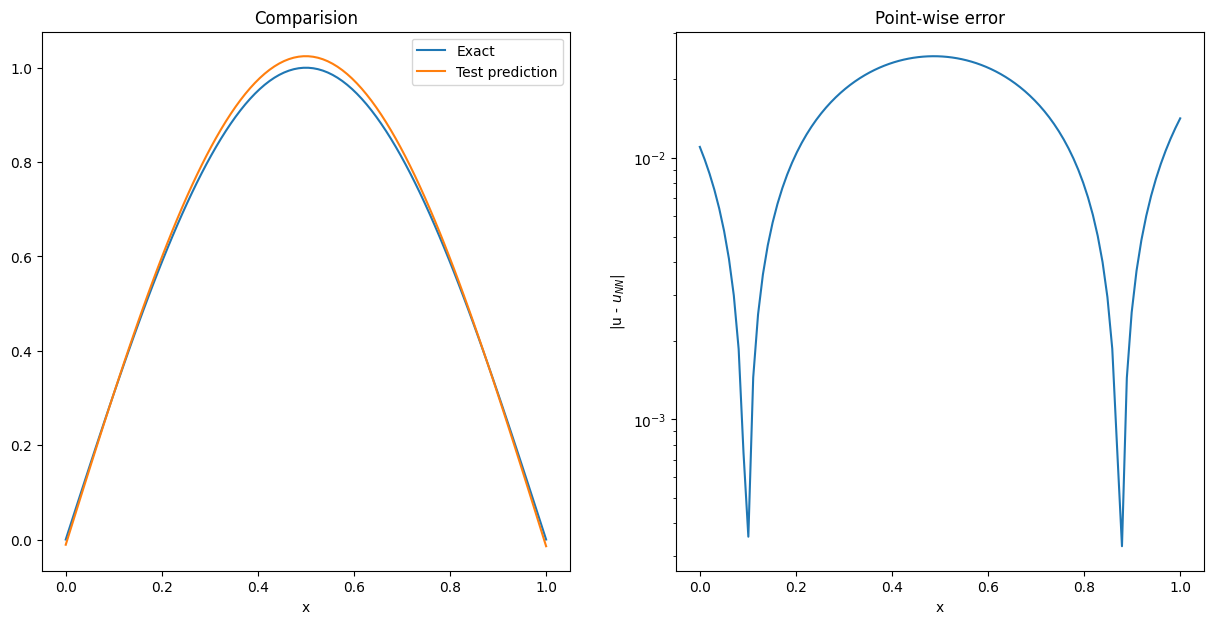

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (15,7))
axs[0].plot(x_test,convert(u_exact_test),label = 'Exact')
axs[0].plot(x_test,u_NN_test, label = 'Test prediction')
axs[0].set_xlabel('x')
axs[0].legend()
axs[0].set_title('Comparision')
axs[0].grid()

axs[1].semilogy(x_test,np.abs(convert(u_exact_test)-u_NN_test))
axs[1].set_title('Point-wise error')
axs[1].set_xlabel('x')
axs[1].set_ylabel('|u - $u_{NN}$|')
plt.show()

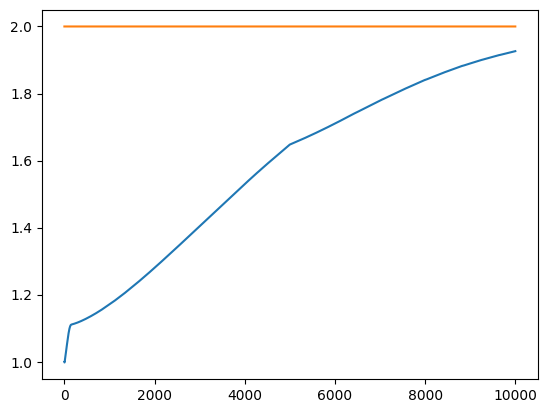

In [ ]:
plt.plot(epochs,alpha_values)
plt.plot(epochs,alpha_exact*np.ones(alpha_values.shape))
plt.grid()